# Plotting a simple variable

In [15]:
import xarray as xr

from dask.distributed import Client
import glob
import catalog
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools


## Connect to cluster

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43093 instead
  warnings.warn(


## Load the data

In [4]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [5]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset>
Dimensions:                           (time: 768, nlat: 384, nlon: 320,
                                       z_t: 60, z_w: 60, lat_aux_grid: 395,
                                       moc_z: 61, d2: 2, z_t_150m: 15,
                                       z_w_bot: 60, z_w_top: 60,
                                       transport_reg: 2, moc_comp: 3,
                                       transport_comp: 5)
Coordinates:
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                      (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                             (moc_z) float32 0.0 1e+03 ... 5.5e+05
  * time                              (time) object 1958-02-01 00:00:00 ... 2...
  * z_t                               (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                          (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                               (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                           (z_w_bot) float32 1e+03 2e+03 ... 5.5e+05
  * z_w_top                           (z_w_top) float32 0.0 1e+03 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/544)
    ADVS                              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    ANGLE                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                                ...
    x_graze_mesozoo_zint              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_mesozoo_zint_100m         (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint             (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint_100m        (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatarag                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatcalc                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 09:15:38 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Super quick plot

We choose to plot temperature. If you're trying this on your own, try replacing `var_to_plot `with some other variables like "SALT" for salinity or "DIC" for dissolved inorganic carbon.

In [19]:
var_to_plot = "TEMP"

We use xarray's `isel()` (select by index) function to grab the first entry in time and vertical coordinate available in our data set. Note that our dataset has some metadata associated with it, so xarray knows that the units are in degrees Celsius without us manually specifying. Xarray's `plot()` function is great for looking at data quickly to make sure things look right before diving into more involved analysis or plotting.

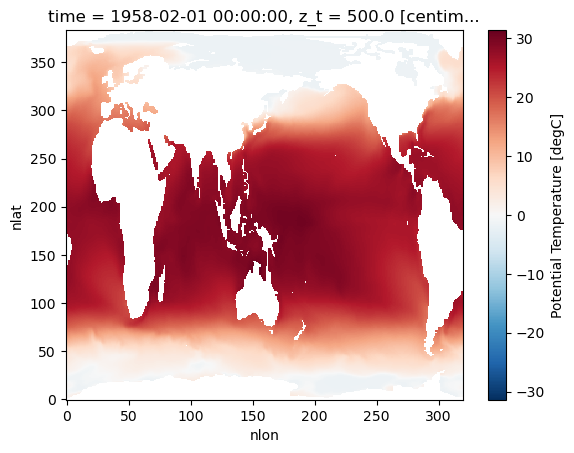

In [30]:
ds[var_to_plot].isel(time=0, z_t=0).plot()

## Making a plot on a nicer map projection

### Bringing in some POP grid tools
This version of CESM uses [POP](https://www.cesm.ucar.edu/models/pop) (the Parallel Ocean Program) as its ocean model. All of the ocean variable output is on the POP grid, which requires some extra wrangling to get it to work properly with standard mapping utilities.

In [8]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Making the map

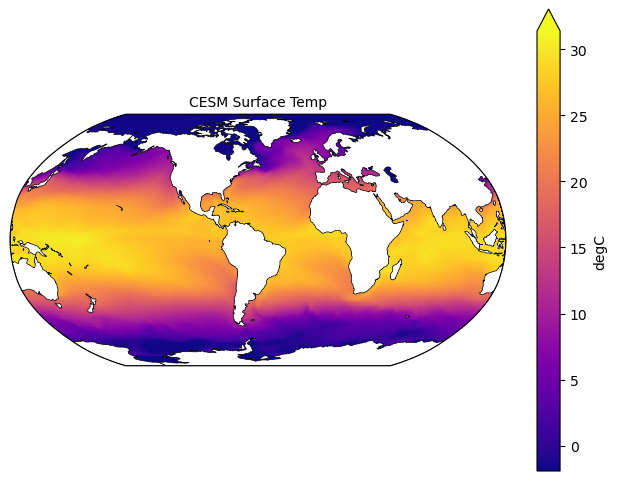

In [31]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

# Using the utilities we added above to process our data, and plotting it
lon, lat, field = adjust_pop_grid(lons, lats, ds[var_to_plot].isel(time=0, z_t=0))
pc1=ax.pcolormesh(lon, lat,field, cmap='plasma',
                 transform=ccrs.PlateCarree())

# Adding the land features
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

# Adding colorbar and title
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label=ds[var_to_plot].units)
ax.set_title('CESM Surface ' + var_to_plot.capitalize(), fontsize=10)

plt.show()